# Imports

In [2]:
from utils import *
import os
import shutil
from PIL import Image
from pytorch_fid import fid_score
import copy
import torch.distributions as D

from torchvision.models import resnet18
from torch import nn
import torch.optim.lr_scheduler as lrsc
import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from config_mnist import *
config = get_configs()


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
wandb.login()
train_loader, val_loader = get_dataset_MNIST(config)

wandb: Currently logged in as: vvoganesyan (use `wandb login --relogin` to force relogin)


In [9]:
a = np.random.rand(3,10)
label = 3

In [21]:
[np.arange(3), label]

[array([0, 1, 2]), 3]

In [18]:
a.shape(0)

TypeError: 'tuple' object is not callable

In [11]:
a

array([[0.74132565, 0.98257441, 0.30329999, 0.39469267, 0.90361997,
        0.10707844, 0.32194522, 0.99094675, 0.90762302, 0.37438134],
       [0.27511855, 0.41577737, 0.92510595, 0.76710089, 0.85178001,
        0.04124238, 0.43768284, 0.50375335, 0.22795274, 0.81031343],
       [0.8862414 , 0.98061549, 0.93794237, 0.30013198, 0.43436167,
        0.05759991, 0.84319424, 0.1453572 , 0.52032426, 0.00570993]])

In [10]:
a[:,label]

array([0.39469267, 0.76710089, 0.30013198])

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out    

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [2]:
# def conv3x3(in_channels, out_channels, stride=1):
#     return nn.Conv2d(in_channels, out_channels, kernel_size=3,
#                     stride=stride, padding=1, bias=False)

class conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(conv3x3, self).__init__()
        self.conv = nn.Conv2d(in_channels+1, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
    def forward(self, x, t):
        t = t.expand(1,x.shape[2],x.shape[3],x.shape[0])
        tt = t.permute((3,0,1,2))
        ttx = torch.cat([tt, x], 1)
        return self.conv(ttx)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x, t):
        residual = x
        out = self.conv1(x, t)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out, t)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample[0](x, t)
            residual = self.downsample[1](residual)
        out += residual
        out = self.relu(out)
        return out

class OutsideLayer(nn.Module):
    def __init__(self, block, in_channels, out_channels, blocks, stride=1):
        super(OutsideLayer, self).__init__()
        self.in_channels = in_channels
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.ModuleList([conv3x3(self.in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels)])
        layers = nn.ModuleList([])
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        self.layers = layers
        
    def forward(self, x, t):
        for layer in self.layers:
            x = layer(x, t)
        return x
    

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = OutsideLayer(block, self.in_channels, 16, layers[0])
        self.in_channels = self.layer1.in_channels
        self.layer2 = OutsideLayer(block, self.in_channels, 32, layers[0], 2)
        self.in_channels = self.layer2.in_channels
        self.layer3 = OutsideLayer(block, self.in_channels, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, t):
        out = self.conv(x, t)
        out = self.bn(out)
        out = self.layer1(out, t)
        out = self.layer2(out, t)
        out = self.layer3(out, t)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
# model = resnet18(num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)
model = model.to(device)
model.train()
optim = torch.optim.RMSprop(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

In [7]:
for epoch in tqdm(range(600)):
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        t = torch.rand(config.data.batch_size).to(device)
        noisy_images = SDE_noise(images, t, device)
        logits = model(noisy_images, t)


        loss = loss_func(logits, labels)
        loss.backward()
        optim.step()
    torch.save(model.state_dict(), 'mnist_noisy_class')

  0%|          | 0/1200 [00:00<?, ?it/s]

In [4]:
model.load_state_dict(torch.load('mnist_noisy_class_t'))

<All keys matched successfully>

In [8]:
sm = nn.Softmax(dim=1)

In [9]:
model.eval()

In [15]:
def cond_s(model, x, t, label):
    x_new = x.clone().detach().requires_grad_(True)
    torch.set_grad_enabled(True)
    logits = model(x_new, t)
    log_probs = torch.log(sm(logits))
    cond_scor = torch.autograd.grad(torch.sum(log_probs[:, label]), x_new)
    torch.set_grad_enabled(False)
    return cond_scor[0]

In [17]:
def sample_cond_sde(model, image_size=32, num_channels=1, batch_size_sample=128):
    x = solve_sde(device,
        torch.randn(batch_size_sample, num_channels, image_size, image_size).to(device),
        f=lambda t, x: -10*t*x - 20*t*s(eps_th, t, x) - 20*t*cond_s(model, x, t, label),
        g=lambda t, x: (20*t) ** 0.5,
        ts=1, tf=0.0, dt=-1e-3
    )
    return x

In [18]:
eps_th = Unet(config)
eps_th.to(device)
ema_ = ema.ExponentialMovingAverage(eps_th.parameters(), decay=0.9999)

In [19]:
state = torch.load(config.model.savepath)
eps_th.load_state_dict(state['model'], strict=False)
ema_.load_state_dict(state['ema'])

In [20]:
ema_.copy_to(eps_th.parameters())
eps_th.eval()

Unet(
  (unet): DDPM(
    (act): SiLU()
    (all_modules): ModuleList(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 32, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=128, out_features=32, bias=True)
        (GroupNorm_1): GroupNorm(32, 32, eps=1e-06, affine=True)
        (Dropout_0): Dropout(p=0.1, inplace=False)
        (Conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 32, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=128, out_fe

In [21]:
label = 0
x = sample_cond_sde(model)

In [22]:
big_img = np.zeros((8*32,8*32),dtype=np.uint8)
for i in range(8):
    for j in range(8):
        y = 0.5*x + 0.5
        p = y[i*8+j] * 255
        p = p.clamp(0, 255)
        p = p.detach().cpu().numpy()
        p = p.astype(np.uint8)
        p = p.transpose((1,2,0))
        p = p.squeeze(2)
        big_img[i*32:(i+1)*32, j*32:(j+1)*32] = p
big_img = Image.fromarray(big_img)

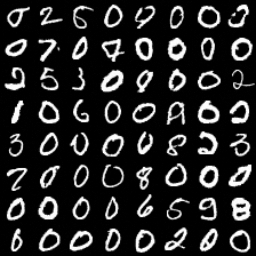

In [23]:
big_img

In [26]:
k=0
for label in range(10):
    x = sample_cond_sde(model)
    logits = model(x, torch.zeros(128).to(device))
    N = 128
    for i in range(N):
        if torch.argmax(logits[i]).cpu() == label:
            k += 1
print(k/(10*N))

0.55078125
